# Matrix and vector computation: the diffusion equation
In this notebook we'll see how matrix computation is performed in Python with an example from statistical mechanics: the diffusion equation, also known as heat equation. This equation describes the macroscopic realization of several microscopic random processes such as the random walk in finance or the brownian motion in chemical physics. At the macroscopic level it is used to describe the movement of particles in a solution or the change of state of atoms in a lattice. 

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

We might look carefully at the diffusion equation to better understand what it means

$$ \frac{\partial u(x, t)}{\partial t} = D \nabla^2 u(x, t)$$

where D is the diffusion coefficient that we assume constant. In one dimension, e.g. x, it is written

$$\frac{\partial u(x, t)}{\partial t} = D \frac{\partial^2 u(x, t)}{\partial x^2}$$

If we use the Euler's method to discretize the partial derivatives we have

$$\frac{u(x, t + \Delta t)}{\Delta t} = D \frac{u(u + \Delta x, t) - u(x - \Delta x, t) - 2u(x, t)}{\Delta x^2}$$

This means that in order to compute the value of u at x for the next time step $t + \Delta t$ we need to know the value of u in the two neighboring grid points at $x - \Delta x$ and at $x + \Delta x$. Once we know the initial value at each grid point we can compute the future value of u at any point in space and at any future time step.  

We want to compute the values of the diffusion equation for all the grid points for a given number of steps. The grid is instantiated as a list array and then it is initialized. The values in a small square region are initialized to represent the state of the system at the beginning of the process.   

In [12]:
def init_grid(grid_shape):
    # grid instantiation
    grid = [[0.0 for x in range(grid_shape[1])] for x in range(grid_shape[0])]
    
    # grid initialization
    block_low = int(grid_shape[0] * 0.4)
    block_high = int(grid_shape[0] * 0.5)
    for i in range(block_low, block_high):
        for j in range(block_low, block_high):
            grid[i][j] = 0.005
    return grid

We use NumPy and Matplotlib to plot the grid

In [70]:
grid_shape = (640, 640)
grid = init_grid(grid_shape)
grid_array = np.array(grid)
grid_array.shape

(640, 640)

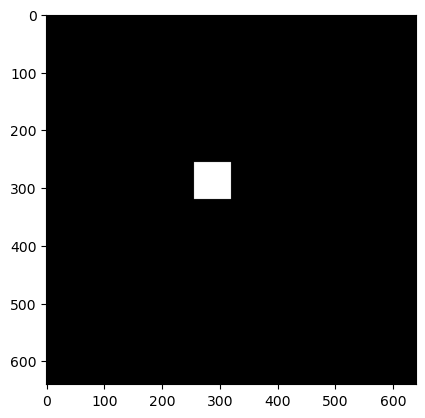

In [75]:
plt.imshow(grid_array, cmap='gray')

We can plot a slice of the grid along the x (horizontal) dimension by setting y at a constant value

In [111]:
grid_x = grid_array[300,:]

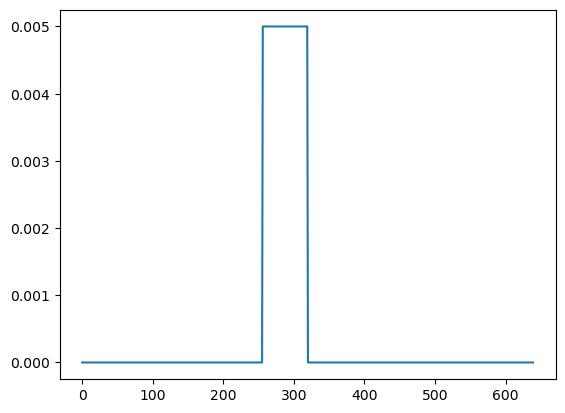

In [112]:
x = np.arange(0, grid_x.shape[0])
plt.plot(x, grid_x)

The *diffuse()* function computes the next value of diffusion equation for each grid point using the Euler's discretization method starting from the values in the input grid.

In [22]:
#@profile
def diffuse(grid, next_grid, grid_shape, dt, D=1.0):
    xmax, ymax = grid_shape
    for i in range(xmax):
        for j in range(ymax):
            grid_xx = (
                grid[(i + 1) % xmax][j] + grid[(i - 1) % xmax][j] - 2.0 * grid[i][j]
            )
            grid_yy = (
                grid[i][(j + 1) % ymax] + grid[i][(j - 1) % ymax] - 2.0 * grid[i][j]
            )
            next_grid[i][j] = grid[i][j] + D * (grid_xx + grid_yy) * dt

The *evolve_grid* function computes the diffuse equation for a number of iteration. We use two grids, one as the initial grid and the second one to store the new values. These grids are swapped at each iteration so that the initial grid is the output of the previous iteration.

In [53]:
def evolve_grid(grid, next_grid, grid_shape, num_iterations):
    # grid evolution
    start_time = time.time()
    for i in range(num_iterations):
        diffuse(grid, next_grid, grid_shape, 0.1)
        grid, next_grid = next_grid, grid # swap the grids so the next computation is done on the output
    end_time = time.time()
    exec_time = end_time - start_time 
    return grid, exec_time

## Performances
We can see that diffusion is a slow process: after 500 steps the change is still within the initial area. From the execution time we can see that the algorithm is also slow. It depends on the way a list store its data. Since a list contains references, the actual data elements must be read one by one from memory, where it was randomly recorded, instead of being read in blocks from the cache. The lack contiguous allocation of data in lists could be solved using a [python array](https://docs.python.org/3.13/library/array.html#array.array) but its method do not allows for vectorized computation so even if it would speed up the algorithm it will not be able to use the CPU at its best. 

execution time:  274.30470395088196


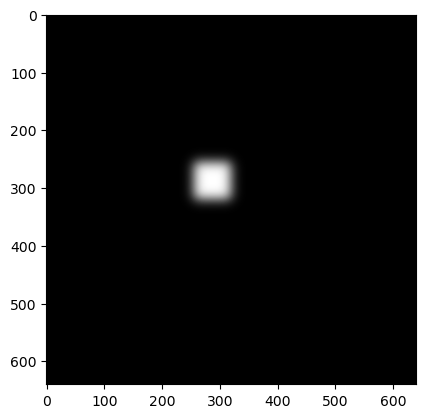

In [76]:
if __name__ == "__main__":
    number_of_steps = 500
    grid_shape = (640, 640)
    grid = init_grid(grid_shape)
    next_grid = init_grid(grid_shape)
    d_grid, t = evolve_grid(grid, next_grid, grid_shape, number_of_steps)
    print('execution time: ', t)
    d_grid_array = np.array(d_grid)
    plt.imshow(d_grid_array, cmap='gray')

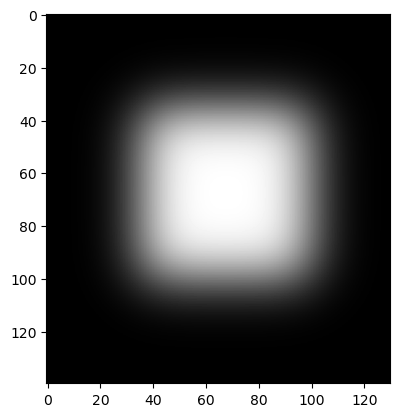

In [77]:
plt.imshow(d_grid_array[220:360, 220:-290], cmap='gray')

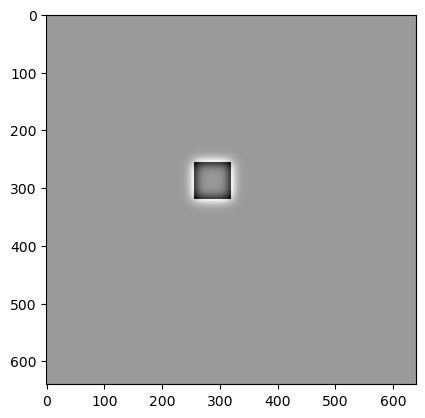

In [79]:
diff_grid = d_grid_array - grid_array
plt.imshow(diff_grid, cmap='gray')

We can plot a horizontal slice of the grid at the same y value as before

In [109]:
d_grid_x = d_grid_array[300,:]

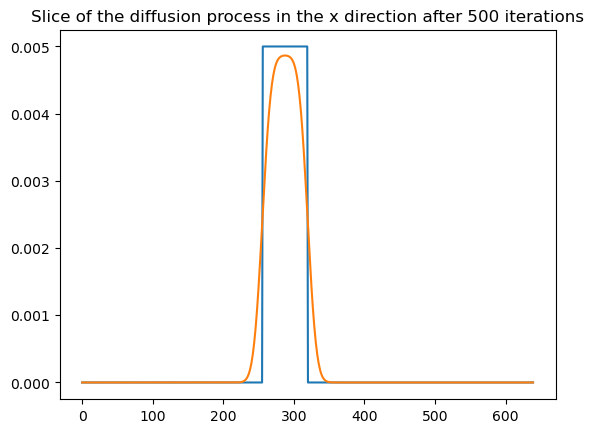

In [146]:
x = np.arange(0, d_x.shape[0])
plt.title('Slice of the diffusion process in the x direction after 500 iterations')
plt.plot(x, grid_x)
plt.plot(x, d_grid_x)